<a href="https://colab.research.google.com/github/plaban1981/Generative_AI/blob/main/OpenAI_API_Function_Calls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Function Calls:

1. Create chatbots that answer questions by **calling external tools** (e.g., like ChatGPT Plugins)

2. Convert **natural language** into API calls or database queries

3. Extract **structured** data from text

### Example 1- Send Email

Email Anya to see if she wants to get coffee next Friday

`send_email(to: string, body: string)`

## Example 2 - Weather API

 What's the weather like in Bengaluru?

 `get_current_weather(location: string, unit: 'celsius' | 'fahrenheit')`


### Example 3 - Natural Language to Function/SQL

Who are my top ten customers this month?

`get_customers_by_revenue(start_date: string, end_date: string, limit: int)`

How many orders did Acme, Inc. place last month?

`sql_query(query: string)`

## Example 4 - Extract Structured Data

Extract details of the names mentioned in this Wikipedia article .....

`extract_people_data(people: [{name: string, birthday: string, location: string}])`

# Code Example

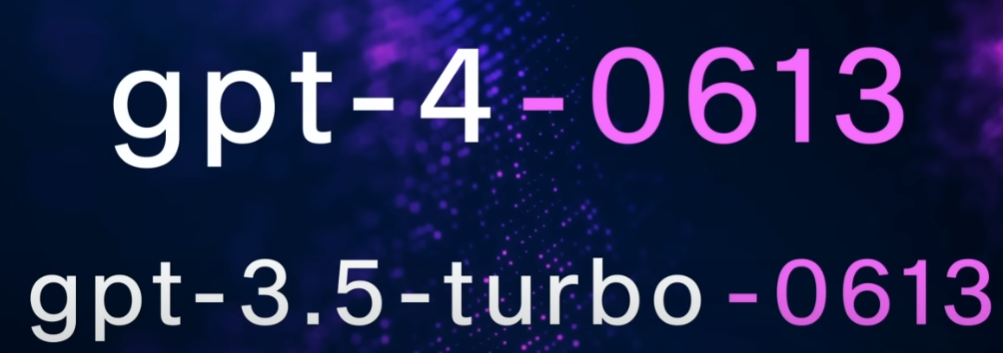

On the 13th June 2023 OpenAI released two new models, gpt-3.5-turbo-0613 and gpt-4-0613. Both models bring a new feature called **function calling to the API**.

**Function calling** allows us to
* describe code functions to the model, and
* the model will identify our intention and
* return a JSON object containing the arguments needed to call the function.
* the Model Completion API does not call the function instead the model generates a JSON that we can use to call the function in our code.

In [1]:
!pip install -qU \
  "openai==0.27.8" \
  "diffusers==0.17.1" \
  "transformers==4.30.2" \
  "accelerate==0.20.3" \
  "scipy==1.10.1" \
  "safetensors==0.3.1" \
  "xformers==0.0.20"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 92.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 14.3 MB/s eta 0:00:00


In [2]:
import openai
from tenacity import retry, wait_random_exponential, stop_after_attempt
from termcolor import colored
import requests

In [3]:
GPT_MODEL = "gpt-3.5-turbo-0613"


In [4]:
from getpass import getpass
openai.api_key = getpass()

··········


In [5]:
@retry(wait=wait_random_exponential(min=1, max=40), stop=stop_after_attempt(3))
def chat_completion_request(messages, functions=None, model=GPT_MODEL):
    headers = {
        "Content-Type": "application/json",
        "Authorization": "Bearer " + openai.api_key,
    }
    json_data = {"model": model, "messages": messages}
    if functions is not None:
        json_data.update({"functions": functions})
    try:
        response = requests.post(
            "https://api.openai.com/v1/chat/completions",
            headers=headers,
            json=json_data,
        )
        return response
    except Exception as e:
        print("Unable to generate ChatCompletion response")
        print(f"Exception: {e}")
        return e

In [6]:
class Conversation:
    def __init__(self):
        self.conversation_history = []

    def add_message(self, role, content):
        message = {"role": role, "content": content}
        self.conversation_history.append(message)

    def display_conversation(self, detailed=False):
        role_to_color = {
            "system": "red",
            "user": "green",
            "assistant": "blue",
            "function": "magenta",
        }
        for message in self.conversation_history:
            print(
                colored(
                    f"{message['role']}: {message['content']}\n\n",
                    role_to_color[message["role"]],
                )
            )

Function Specification

In [7]:
functions = [
    {
        "name": "get_current_weather",
        "description": "Get the current weather",
        "parameters": {
            "type": "object",
            "properties": {
                "location": {
                    "type": "string",
                    "description": "The city and state, e.g. San Francisco, CA",
                },
                "format": {
                    "type": "string",
                    "enum": ["celsius", "fahrenheit"],
                    "description": "The temperature unit to use. Infer this from the users location.",
                },
            },
            "required": ["location", "format"],
        },
    }
]

In [8]:
conversation = Conversation()


In [9]:
conversation.add_message("user", "what is the weather like today in Bangalore")


In [10]:
conversation

In [11]:
#without function call
chat_response = chat_completion_request(
    conversation.conversation_history,
    functions = None
)
print(chat_response)

<Response [200]>


In [12]:
chat_response.text

'{\n  "id": "chatcmpl-7S5HC2GyZc3gToCDObC6QyOfyZiPq",\n  "object": "chat.completion",\n  "created": 1686927822,\n  "model": "gpt-3.5-turbo-0613",\n  "choices": [\n    {\n      "index": 0,\n      "message": {\n        "role": "assistant",\n        "content": "I\'m sorry, but as an AI language model, I don\'t have real-time data. You can check the weather today in Bangalore by referring to a reliable weather website or using a weather application on your mobile device."\n      },\n      "finish_reason": "stop"\n    }\n  ],\n  "usage": {\n    "prompt_tokens": 15,\n    "completion_tokens": 44,\n    "total_tokens": 59\n  }\n}\n'

In [17]:
type(chat_response.text)

str

In [18]:
#with function call
chat_response = chat_completion_request(
    conversation.conversation_history,
    functions = functions
)

chat_response.json()

{'id': 'chatcmpl-7S5JJcnRPIBiuYujH6U08IS37xe7o',
 'object': 'chat.completion',
 'created': 1686927953,
 'model': 'gpt-3.5-turbo-0613',
 'choices': [{'index': 0,
   'message': {'role': 'assistant',
    'content': None,
    'function_call': {'name': 'get_current_weather',
     'arguments': '{\n  "location": "Bangalore",\n  "format": "celsius"\n}'}},
   'finish_reason': 'function_call'}],
 'usage': {'prompt_tokens': 92, 'completion_tokens': 25, 'total_tokens': 117}}

In [21]:
import json
chat_response.json()['choices'][0]['message']

{'role': 'assistant',
 'content': None,
 'function_call': {'name': 'get_current_weather',
  'arguments': '{\n  "location": "Bangalore",\n  "format": "celsius"\n}'}}

In [22]:
import json
json.loads(chat_response.json()['choices'][0]['message']['function_call']['arguments'])

{'location': 'Bangalore', 'format': 'celsius'}

In [23]:
conversation.add_message("user", "what is the weather like today in Berlin")


In [24]:
#with function call
chat_response = chat_completion_request(
    conversation.conversation_history,
    functions = functions
)

chat_response.json()

{'id': 'chatcmpl-7S5KiI9bmc5OT1ovUjG1VGNVUdKaz',
 'object': 'chat.completion',
 'created': 1686928040,
 'model': 'gpt-3.5-turbo-0613',
 'choices': [{'index': 0,
   'message': {'role': 'assistant',
    'content': None,
    'function_call': {'name': 'get_current_weather',
     'arguments': '{\n  "location": "Berlin",\n  "format": "celsius"\n}'}},
   'finish_reason': 'function_call'}],
 'usage': {'prompt_tokens': 104, 'completion_tokens': 24, 'total_tokens': 128}}

In [25]:
import json
json.loads(chat_response.json()['choices'][0]['message']['function_call']['arguments'])

{'location': 'Berlin', 'format': 'celsius'}

In [26]:
# confirm authentication was successful
openai.Engine.list()['data'][0]

<Engine engine id=whisper-1 at 0x7f72d6c276a0> JSON: {
  "object": "engine",
  "id": "whisper-1",
  "ready": true,
  "owner": "openai-internal",
  "permissions": null,
  "created": null
}

##  create a function that we will be using GPT-4 to call

In [27]:
from IPython.display import HTML

def page_builder(title: str, copy_text: str):
    """Takes title and copy text to create a product page in simple HTML
    """
    html = """


        Awesome Product




            """+title+"""
            """+copy_text+"""


"""
    with open('index.html', 'w') as fp:
        fp.write(html)
    return HTML(filename='index.html')

In [28]:
page_builder(
    title="Awesome Product",
    copy_text="Not very good copy text (it was written by a human)."
)

In [29]:
HTML("/content/index.html")

## Now let's ask GPT-4 to create the input to our function. We translate the function above into a function GPT-4 understands with:

In [30]:
page_builder_func = {
    "name": "page_builder",
    "description": "Creates product web pages",
    "parameters": {
        "type": "object",
        "properties": {
            "title": {
                "type": "string",
                "description": "The name of the product"
            },
            "copy_text": {
                "type": "string",
                "description": "Marketing copy that describes and sells the product"
            }
        },
        "required": ["title", "copy_text"]
    }
}